# Drone Tutorial - Companion Notebook
Welcome to the Drone Tutorial's Companion Notebook.  This is the Jupyter notebook counterpart of the drone tutorial on the HEART Documentation website. This notebook contains the all the necessary code to replicate the tutorial's steps on your own.  You will be able to follow the tutorial on the website while also running the code in real-time from this notebook. Additionally, we highly encourage you to use the code form this notebook as a baseline for your own learning, experiments, testing, and uses cases.  Feel free to edit the code for your needs and try HEART with your own models and data sets.

The structure and flow of this notebook follows the Tutorial's:

1. Part - Environment Set up and Data Load
    * 1.1. Libraries Import
    * 1.2. Loading Drone Dataset and Object Detection Model
    * 1.3. Confirming Model Performance
2. Part - Attacking the Model
    * 2.1 Creating adversarial Examples with HEART
    * 2.2 Produce Results and Comparison Metrics with HEART
3. Part - Defending the Model and Advanced Attacks
    * 3.1 Defending the Model
    * 3.2 Advanced Attacks 

## Part 1 - Environment Set up and Data Load

### 1.1 Libraries Import

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

On the tutorial webpage, this code is in the code dropdown *Code: Import Statements for Necessary Imports*. 

In [13]:
# general imports
import numpy as np
from functools import partial
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
from copy import deepcopy

# imports from ART
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import AdversarialPatchPyTorch
from art.defences.preprocessor import JpegCompression

# imports from HEART
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector
from heart_library.attacks.attack import JaticAttack
from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.metrics import HeartMAPMetric, HeartAccuracyMetric

# dataset imports
from datasets import load_dataset
from datasets import Dataset

# torch imports
import torch
from torchvision.transforms import transforms

# MAITE imports
from maite.protocols.object_detection import TargetBatchType
from maite.workflows import evaluate
from maite.protocols.object_detection import Dataset as od_dataset
from maite.protocols.image_classification import Augmentation
from maite.utils.validation import check_type

plt.style.use('ggplot')
%matplotlib inline

### 1.2 Loading Drone Dataset and Object Detection Model

Before loading data and model, we define a couple of methods that we will use later on on the drone data. These encompass getting predictions with a confidence threshold, plotting input images with the predicted bounding boxes, and a special wrapper for image data.

In the tutorial webpage, these are in the code dropdown *Code: Defining Methods for Use Later with Drone Data*.

In [14]:
# given a confidence threshold, determine which of the mdoel's predictions are relevent
def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [visdrone_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

#plot an image with objects with the predicted bounding boxes on top
def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 1.5
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()
    
#wrapper for image datasets 
class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.images)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = np.asarray(self.images[ind]["image"]).astype(np.float32)
        
        filtered_detection = self.groundtruth[ind]
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

# specific dataset class to craft a targeted adversarial patch 
class TargetedImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, target_label, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.boxes = targeted_detection.boxes[targeted_detection.scores>self.threshold]
        targeted_detection.scores = np.asarray([1.0]*len(targeted_detection.boxes))
        targeted_detection.labels = [self.target_label]*len(targeted_detection.boxes)
        return (image, targeted_detection, {})

Before loading the data, we define the labels for the bounding boxes. Afterwards, we load a small number of samples to save compute during using this notebook. 

This is the first code cell shown in the tutorial webpage.

In [15]:
visdrone_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

NUM_SAMPLES = 5

data = load_dataset("Voxel51/VisDrone2019-DET", split="train", streaming=True)
sample_data = data.take(NUM_SAMPLES)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

sample_data = Dataset.from_generator(partial(gen_from_iterable_dataset, sample_data), features=sample_data.features)

IMAGE_H, IMAGE_W = 800, 800

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

sample_data = sample_data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Resolving data files:   0%|          | 0/8632 [00:00<?, ?it/s]

We conclude by loading an object detector based on ResNet50, which we wrap as a JATIC classifier for further evaluation and inspect to classified images.

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


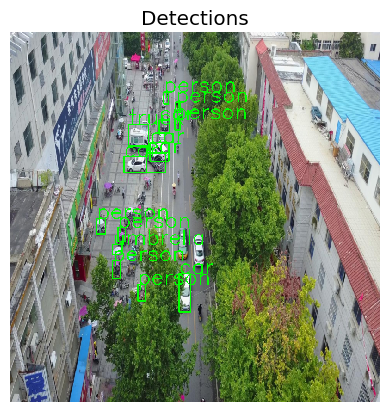

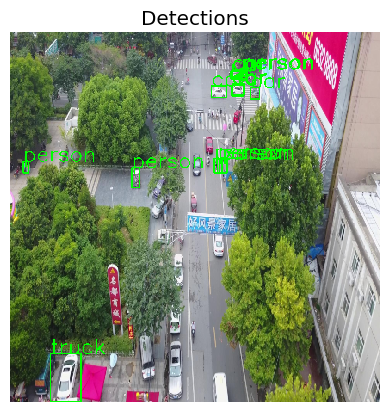

In [24]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      device_type='cpu',
                                    input_shape=(3, 800, 800),
                                    clip_values=(0, 1), 
                                    attack_losses=("loss_ce",), 
                                    preprocessing=(MEAN, STD))

detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(2): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.8)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

The above figures show example object detection outputs. We overlay the predictions from the output detector (light green) in terms of bounding boxes (squares) and class (text) with the input image.

To confirm our intuition of the good performance of the object detector, we compute the average precision metric from HEART.

### 1.3 Confirming model performance

We now compute the mean average precision to understand the performance of the model.

This code is as well contained in the tutorial webpage.

In [17]:
#parameters to configure the performance metric
map_args = {"box_format": "xyxy",
            "iou_type": "bbox",
            "iou_thresholds": [0.5],
            "rec_thresholds": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "max_detection_thresholds": [1, 10, 100],
            "class_metrics": False,
            "extended_summary": False,
            "average": "macro"}

data_with_detections = ImageDataset(sample_data, deepcopy(detections), threshold=0.8)

assert isinstance(data_with_detections, od_dataset)

metric = HeartMAPMetric(**map_args)

results, _, _ = evaluate(
    model=detector, 
    dataset=data_with_detections,
    metric=metric,
)

print('Benign evaluation:')

pprint(results)

  0%|          | 0/5 [00:00<?, ?it/s]

Benign evaluation:
{'classes': tensor([ 1,  2,  3,  6,  8, 10, 15, 28, 35, 36, 77], dtype=torch.int32),
 'map': tensor(1.),
 'map_50': tensor(1.),
 'map_75': tensor(-1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(1.),
 'mar_1': tensor(0.69720),
 'mar_10': tensor(0.96739),
 'mar_100': tensor(1.),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(1.),
 'mar_small': tensor(1.)}


Our intuition is confirmed, the mean average precision on the 5 test images is 1.

Consider that several values here are -1. This includes for example map_75, as 75 was not given as a threshold parameter to the metric. In addition, map_large is -1, as this is computed over large objects (area > 96^2 pixels), which are not in our samples. Finally, some of the _per_class metrics are -1, as we did not provide samples for all classes. 

## Part 2 - Attacking the model

In the second part, we will security test the model by attacking it. 

### 2.1 Creating adversarial examples with HEART

We use the projected gradient descent (PGD) attack and run the attack in a MAITE evaluation that returns relevant statistics about the models performance.

In [18]:
# repeat parameters for model evaluation
map_args = {"box_format": "xyxy",
            "iou_type": "bbox",
            "iou_thresholds": [0.5],
            "rec_thresholds": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "max_detection_thresholds": [1, 10, 100],
            "class_metrics": False,
            "extended_summary": False,
            "average": "macro"}

#initialize attack
attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=1, eps_step=0.01, eps=0.03, targeted=False, verbose=False), norm=2)

data_with_detections = ImageDataset(sample_data, deepcopy(detections), threshold=0.9)

assert isinstance(data_with_detections, od_dataset)

isinstance(attack, Augmentation)

metric = HeartMAPMetric(**map_args)

check_type('attack', attack, Augmentation)

results, _, _ = evaluate(
    model=detector, 
    dataset=data_with_detections,
    metric=metric,
    augmentation=attack,
)

print('PGD evaluation:')
pprint(results)

  0%|          | 0/5 [00:00<?, ?it/s]

PGD evaluation:
{'classes': tensor([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 14, 15, 27, 28, 56, 64], dtype=torch.int32),
 'map': tensor(0.08463),
 'map_50': tensor(0.08463),
 'map_75': tensor(-1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(0.15476),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.14274),
 'mar_1': tensor(0.03261),
 'mar_10': tensor(0.13354),
 'mar_100': tensor(0.19876),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(0.26923),
 'mar_small': tensor(0.31429)}


From the metric, we see that the attack indeed severely affects the performance: map is down to 0.085.

### 2.2 Produce Results and Comparison Metrics with HEART

Afterwards, we plot the images for visual inspection.

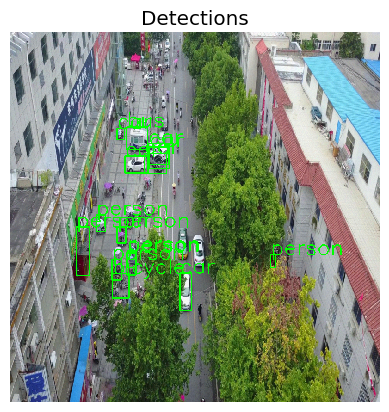

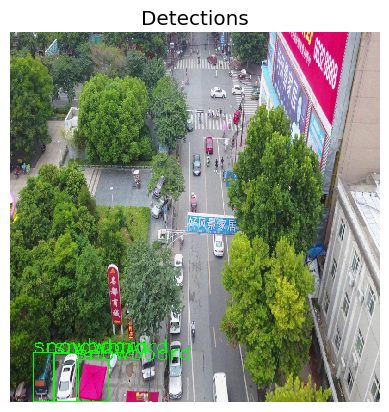

In [25]:
x_advPGD, y, metadata = attack(data=sample_data)
detections = detector(np.stack(x_advPGD))

#plot images and predictions for two images
for i in range(2): #for all, write range(len(x_adv)):
    preds_orig = extract_predictions(detections[i], 0.8)
    img = np.asarray(x_advPGD[i].transpose(1,2,0))
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

The above figures again depict the object detectors output on the images, but this time with the adversarial perturbation added. Compared to the previous images, we see that less objects are detected, but also wrong objects (like for example snowboards) appear.

## Part 3: Defending the Model and Advanced Attacks


### 3.1 Defending the Model

We implement JPEG compression as an exemplary defense. In this case, JPEG compression is used on the input.

Using cache found in /Users/kgr/.cache/torch/hub/facebookresearch_detr_main


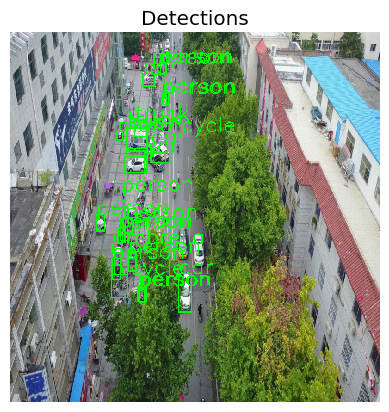

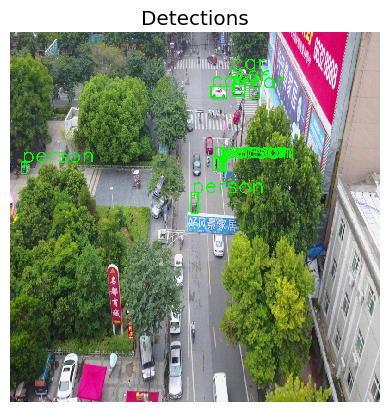

In [26]:
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=40 
                                        )

detector_defended = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                                device_type='cpu',
                                                input_shape=(3, 800, 800),
                                                clip_values=(0, 1), 
                                                attack_losses=( "loss_ce",
                                                    "loss_bbox",
                                                    "loss_giou",), 
                                                preprocessing=(MEAN, STD),
                                                preprocessing_defences=[preprocessing_defense])


#View detections on adversarial images
adv_detections = detector_defended(x_advPGD)

for i in range(2): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.8)
    plot_image_with_boxes(img=x_advPGD[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

These images depict once more the adversarial images and the output detectors assessment, however this time with a defense that will remove some of the adversarial perturbation. We see, compared to the undefended detector, that again more objects are classified correctly. 

In [21]:
map_args = {"box_format": "xyxy",
            "iou_type": "bbox",
            "iou_thresholds": [0.5],
            "rec_thresholds": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "max_detection_thresholds": [1, 10, 100],
            "class_metrics": False,
            "extended_summary": False,
            "average": "macro"}

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=1, eps_step=0.01, eps=0.03, targeted=False, verbose=False), norm=2)

data_with_detections = ImageDataset(sample_data, deepcopy(detections), threshold=0.9)

'''out'''
assert isinstance(data_with_detections, od_dataset)

isinstance(attack, Augmentation)

check_type('attack', attack, Augmentation)
'''in'''
metric = HeartMAPMetric(**map_args)

results, _, _ = evaluate(
    model=detector_defended, 
    dataset=data_with_detections,
    metric=metric,
    augmentation=attack,
)

print('PGD evaluation:')
pprint(results)

  0%|          | 0/5 [00:00<?, ?it/s]

PGD evaluation:
{'classes': tensor([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 14, 28, 36, 56, 64, 77, 85], dtype=torch.int32),
 'map': tensor(0.09041),
 'map_50': tensor(0.09041),
 'map_75': tensor(-1.),
 'map_large': tensor(0.),
 'map_medium': tensor(0.10303),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.13803),
 'mar_1': tensor(0.03182),
 'mar_10': tensor(0.13712),
 'mar_100': tensor(0.18409),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.),
 'mar_medium': tensor(0.11538),
 'mar_small': tensor(0.53571)}


HEARTs MAP matric confirms our intuition that the model is better in terms of performance: the map increased slightly to 0.9041 from previously 0.08463 under attack.

## 3.2 Advanced Attacks

The previous attack is rather easy to defend for the JPEG compression: The perturbation added are small pixel changes to the entire image, which are easily removed by the compression. To avoid this defense, we will now use an adaptive attack that exploits knowledge about the defense: We will craft a patch attack instead. The patch is a strong, local perturbation, that is limited to a small area of the image. The JPEG compression is thus less likely to alter the perturbation strongly.

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

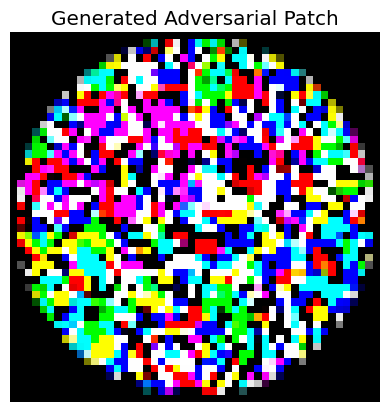

-------------


In [30]:
##### repeat with patch attack
detections = detector(sample_data)
targeted_data = TargetedImageDataset(sample_data, deepcopy(detections), NUM_SAMPLES)

assert isinstance(targeted_data, od_dataset)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(1)))

rotation_max=0.0
scale_min=0.5
scale_max=1.0
distortion_scale_max=0.0
learning_rate=0.9
max_iter=50
batch_size=16
patch_shape=(3, 50, 50)
patch_location=(20,20)
patch_type="circle"
optimizer="Adam"

patchAttack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

#Generate adversarial images
px_adv, y, metadata = patchAttack(data=targeted_data)

patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

Above, we see the adversarial patch computed by the attack. Below, we plot several images with the patch in the upper, left corner. 

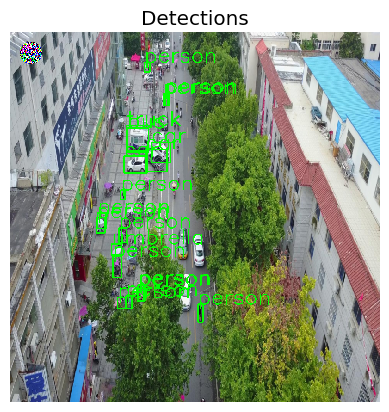

In [31]:
adv_detections = detector_defended(px_adv)
for i in range(1): #to see all, use range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.8)
    plot_image_with_boxes(img=px_adv[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

We now rerun the preprocessing defense. As expected, we see little difference between the original, undefended and the defended model, highlighting the need for good T&E once more.

Part 4 of the Tutorial is a conclusion/wrap-up, so there is no further code.  This is the end of the Drone Tutorial Jupyter Companion Notebook.